`timm` is a package that contains some useful pretrained models

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 9.9 MB/s eta 0:00:00


## IMPORT

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_v2_m, EfficientNet_V2_M_Weights
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import torch
import os
import cv2
import random
from torchvision import datasets, models, transforms
from PIL import Image
import timm

###Folder

In [ ]:
drive.mount('/content/drive/')
data_dir = '/content/drive/MyDrive/VISIOPE_PROJECT/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/VISIOPE_PROJECT/models

/content/drive/MyDrive/VISIOPE_PROJECT/models


## Prediction function

This function takes the folder containing the test data, assign them a label and then proceed with `prediction`

In [ ]:
def predict(path_original, path_fake, model):

  directory_dataset = path_original
  dataset_list = []
  for filename in os.listdir(directory_dataset):
    file_path = directory_dataset + '/' + filename
    img_color = cv2.imread(file_path,1)
    dic = {'image': file_path, 'label': 1}
    dataset_list.append(dic)

  # -------------------------------------------------------------------------------------------------------
  directory_dataset = path_fake

  for filename in os.listdir(directory_dataset):
    file_path = directory_dataset + '/' + filename
    img_color = cv2.imread(file_path,1)
    dic = {'image': file_path, 'label': 0}
    dataset_list.append(dic)

  random.shuffle(dataset_list)

  good_prediction = 0
  preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )])

  # Pass the image for preprocessing and the image preprocessed

  count = 0
  count_wrong = 0
  for t in dataset_list:
    key = t.get("image")
    value = t.get("label")
    img_preprocess = preprocess(Image.open(key).convert('RGB'))
    batch_img_tensor = torch.unsqueeze(img_preprocess, 0)
    model.eval()
    with torch.no_grad():
      out = model(batch_img_tensor.cuda())

    labels = ["real", "fake"]
    _, index = torch.max(out, 1)
    predicted_class = np.argmax(out.cpu())

    if predicted_class == 1:
      predicted_class = 'real'
    else:
      predicted_class = 'fake'
    if value == 1:
      value = 'real'
    else:
      value = 'fake'
    if predicted_class == value:
      good_prediction+=1
      
  print(f'Good: {good_prediction/len(dataset_list)}')
  return good_prediction/len(dataset_list)

# PREDICTION RESNET50, TRAINED ON DEEPFAKE

## LOAD THE MODEL

In [ ]:
model_resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 2)

model_resnet50 = model_resnet50.to(device)
# model_resnet50.load_state_dict(torch.load("resnet50_deepfake_NORMAL_MIX.pt"))
model_resnet50.load_state_dict(torch.load("resnet50_deepfake_NORMAL.pt"))
# model_resnet50.load_state_dict(torch.load("resnet50_deepfake_FREEZE.pt"))
# model_resnet50.load_state_dict(torch.load("resnet50_deepfake_NORMAL_ADAM.pt"))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

##Test for each manipulation

In this section, after have loaded a model, there's a prediction using that model on the manipulation where it has been trained and on the others manipulations.

In [ ]:
acc_resnet50 = {}
path_original = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/original'

path_deepfake = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/deepfake'
good_deepfake = predict(path_original, path_deepfake, model_resnet50)

path_face2face = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/face2face'
good_face2face = predict(path_original, path_face2face, model_resnet50)

path_faceswap = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/faceswap'
good_faceswap = predict(path_original, path_faceswap, model_resnet50)

path_neuraltexture= '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/neuraltexture'
good_neuraltexture = predict(path_original, path_neuraltexture, model_resnet50)

acc_resnet50["NeuralTexture"] = good_neuraltexture
acc_resnet50["FaceSwap"] = good_faceswap
acc_resnet50["Face2Face"] = good_face2face
acc_resnet50["DeepFake"] = good_deepfake

Good: 0.9811320754716981
Good: 0.57
Good: 0.49
Good: 0.6


## PREDICTION WITH ADAM OPTIMIZER



> In this section there's a proof about the perfomance of a model trained on DeepFake using Adam optimizer



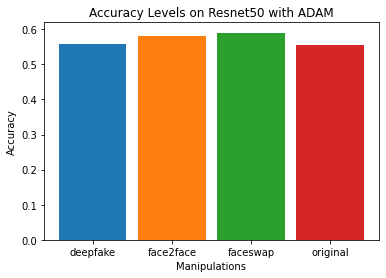

In [ ]:
# X_axis = ['deepfake', 'face2face', 'faceswap', 'original']
X1_axis = ['deepfake']
X2_axis = ['face2face']
X3_axis = ['faceswap']
X4_axis = ['original']

# Plot the first dictionary
plt.bar(X1_axis, acc_resnet50.get("DeepFake"), 0.85, label = "Deepfake")
plt.bar(X2_axis, acc_resnet50.get("Face2Face"), 0.85, label = "Face2Face")
plt.bar(X3_axis, acc_resnet50.get("FaceSwap"), 0.85, label = "FaceSwap")
plt.bar(X4_axis, acc_resnet50.get("NeuralTexture"), 0.85, label = "Real")

#fig, ax = plt.subplots()
#ax.bar(emoticons, accuracies)

#plt.xticks(X_axis, acc_resnet50.keys())
plt.xlabel("Manipulations")
plt.ylabel("Accuracy")
plt.title("Accuracy Levels on Resnet50 with ADAM")

# Add a legend to identify the different data sets
# plt.legend()

plt.show()

# PREDICTION XCEPTION, TRAINED ON FACE2FACE

## LOAD THE MODEL

In [ ]:
model_xception = timm.create_model('xception', pretrained=True)
num_ftrs = model_xception.fc.in_features
model_xception.last_linear = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    #nn.Dropout(p=0.5),
    nn.Linear(512, 2) # 2 perchè è un problema di binary classification
)
model_xception = model_xception.to(device)

model_xception = model_xception.to(device)
model_xception.load_state_dict(torch.load("xception_face2face_50epochs_FREEZE_Def.pt"))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


<All keys matched successfully>

##Test for each manipulation

In [ ]:
acc_xception = {}
path_original = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/original'

path_deepfake = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/deepfake'
good_deepfake = predict(path_original, path_deepfake, model_xception)

path_face2face = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/face2face'
good_face2face = predict(path_original, path_face2face, model_xception)

path_faceswap = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/faceswap'
good_faceswap = predict(path_original, path_faceswap, model_xception)

path_neuraltexture= '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/neuraltexture'
good_neuraltexture = predict(path_original, path_neuraltexture, model_xception)

acc_xception["NeuralTexture"] = good_neuraltexture
acc_xception["FaceSwap"] = good_faceswap
acc_xception["Face2Face"] = good_face2face
acc_xception["DeepFake"] = good_deepfake

Good: 0.5613207547169812
Good: 0.97
Good: 0.54
Good: 0.505


# PREDICTION EffiecientNet, TRAINED ON FACESWAP

## LOAD THE MODEL

In [ ]:
model_efficientnet = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights)

num_ftrs = model_efficientnet.classifier[1].in_features

model_efficientnet.classifier[1] = nn.Linear(num_ftrs, 2)

model_mobilenetv2 = model_efficientnet.to(device)
model_mobilenetv2.load_state_dict(torch.load("efficientnet_faceswap_NORMAL.p"))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

<All keys matched successfully>

##Test for each manipulation

In [ ]:
acc_efficientnet = {}
path_original = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/original'

path_deepfake = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/deepfake'
good_deepfake = predict(path_original, path_deepfake, model_mobilenetv2)

path_face2face = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/face2face'
good_face2face = predict(path_original, path_face2face, model_mobilenetv2)

path_faceswap = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/faceswap'
good_faceswap = predict(path_original, path_faceswap, model_mobilenetv2)

path_neuraltexture= '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/neuraltexture'
good_neuraltexture = predict(path_original, path_neuraltexture, model_mobilenetv2)

acc_efficientnet["NeuralTexture"] = good_neuraltexture
acc_efficientnet["FaceSwap"] = good_faceswap
acc_efficientnet["Face2Face"] = good_face2face
acc_efficientnet["DeepFake"] = good_deepfake

Good: 0.4669811320754717
Good: 0.595
Good: 0.985
Good: 0.495


#Plot the architecture accuracies

```
# plt.bar(x, height, width, bottom, align)
```



*   x: This parameter is used to specify the x coordinates of the bars. It can be a list or an array of x-coordinates.
*   height: This parameter is used to specify the height of the bars. It can be a list or an array of heights.
*   width: This parameter is used to specify the width of the bars. It is optional, if not set the default width is 0.8.
*   bottom: This parameter is used to specify the y coordinates of the bars. It can be a list or an array of y-coordinates. If not specified, the bars will be drawn from the x-coordinates.
*   align: This parameter is used to specify the alignment of the bars with respect to the x-coordinates. It can take the values center, edge or None. If not specified, the default value is 'center'.









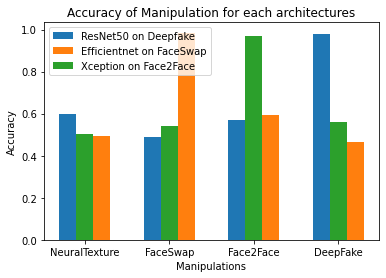

In [ ]:
X_axis = np.arange(len(acc_resnet50.keys()))
# Plot the first dictionary
plt.bar(X_axis - 0.2, acc_resnet50.values(), 0.2, label = "ResNet50 on Deepfake")
plt.bar(X_axis + 0.2, acc_efficientnet.values(), 0.2, label = "Efficientnet on FaceSwap")
plt.bar(X_axis, acc_xception.values(), 0.2, label = "Xception on Face2Face")

plt.xticks(X_axis, acc_resnet50.keys())
plt.xlabel("Manipulations")
plt.ylabel("Accuracy")
plt.title("Accuracy of Manipulation for each architectures")
# Add a legend to identify the different data sets
plt.legend()

plt.show()

# PREDICTION MULTICLASS

In [ ]:
data_dir='/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test_MultiClassification'

## Prediction function

In [ ]:
preprocess_test = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )])

image_datasets =datasets.ImageFolder(data_dir,preprocess_test)
dataloaders_test = torch.utils.data.DataLoader(image_datasets, batch_size=4, shuffle=True)
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes
names_to_idx=image_datasets.class_to_idx

In [ ]:
print(class_names[0])
print(class_names[1])
print(class_names[2])
print(class_names[3])

deepfake
face2face
faceswap
original


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




> In this case, we have used a different prediction function, using directly the dataloader instead that a dictionary where the label was set manually.



In [ ]:
from collections import Counter
def predict_test(model):
  
  # Pass the image for preprocessing and the image preprocessed
  num_elem=dict(Counter(image_datasets.targets))
  ss={'deepfake':0, 'face2face':0, 'faceswap':0, 'original':0 }
  res={'deepfake':0, 'face2face':0, 'faceswap':0, 'original':0 }
  model.eval()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders_test):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #print(f'Input:{inputs}')
        #print(f'Labels:{labels}')

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        """print(f'Prediction:{preds}')
        print(f'Input size: {inputs.size()[0]}')
        print(f'Class names: {class_names}')"""

        for j in range(inputs.size()[0]):
          #print(f'predicted: {class_names[preds[j]]}')
          #imshow(inputs.cpu().data[j])
          if class_names[preds[j]] == class_names[labels[j]]:
            ss[class_names[preds[j]]]+=1

  for i in ss.keys():
    res[i]=ss[i]/num_elem[names_to_idx[i]]
    print(f'Good {i}:{res[i]}')
    print("Numero totale di elementi:", num_elem[names_to_idx[i]])
  
  return res, ss
    

In [ ]:
%cd /content/drive/MyDrive/VISIOPE_PROJECT/models

/content/drive/MyDrive/VISIOPE_PROJECT/models


## LOAD THE MODEL

In [ ]:
model_resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 4)

model_resnet50 = model_resnet50.to(device)
model_resnet50.load_state_dict(torch.load("resnet50_deepfake_NORMAL_MULTICLASS.pt"))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
res, ss = predict_test(model_resnet50)

Good deepfake:0.9642857142857143
Numero totale di elementi: 112
Good face2face:0.92
Numero totale di elementi: 100
Good faceswap:0.96
Numero totale di elementi: 100
Good original:0.89
Numero totale di elementi: 100


## PLOT THE RESULTS

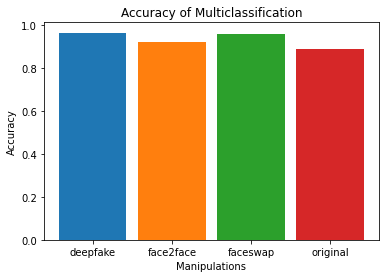

In [ ]:
# X_axis = ['deepfake', 'face2face', 'faceswap', 'original']
X1_axis = ['deepfake']
X2_axis = ['face2face']
X3_axis = ['faceswap']
X4_axis = ['original']

# Plot the first dictionary
plt.bar(X1_axis, res.get('deepfake'), 0.85, label = "Deepfake")
plt.bar(X2_axis, res.get('face2face'), 0.85, label = "Face2Face")
plt.bar(X3_axis, res.get('faceswap'), 0.85, label = "FaceSwap")
plt.bar(X4_axis, res.get('original'), 0.85, label = "Real")

#fig, ax = plt.subplots()
#ax.bar(emoticons, accuracies)

#plt.xticks(X_axis, acc_resnet50.keys())
plt.xlabel("Manipulations")
plt.ylabel("Accuracy")
plt.title("Accuracy of Multiclassification")

# Add a legend to identify the different data sets
# plt.legend()

plt.show()

# PREDICTION USING MIXED TRAINED MODEL

In this case we're making a `binary prediction`

In [ ]:
def predict_mix(path_original, path_deepfake, path_face2face, path_faceswap, path_neuraltexture, model):

  directory_dataset = path_original
  
  dataset_list = []
  for filename in os.listdir(directory_dataset):
    file_path = directory_dataset + '/' + filename
    img_color = cv2.imread(file_path,1)
    dic = {'image': file_path, 'label': 1}
    dataset_list.append(dic)

  directory_dataset = path_deepfake

  for filename in os.listdir(directory_dataset):
    file_path = directory_dataset + '/' + filename
    img_color = cv2.imread(file_path,1)
    dic = {'image': file_path, 'label': 0}
    dataset_list.append(dic)
  
  directory_dataset = path_face2face

  for filename in os.listdir(directory_dataset):
    file_path = directory_dataset + '/' + filename
    img_color = cv2.imread(file_path,1)
    dic = {'image': file_path, 'label': 0}
    dataset_list.append(dic)
  
  directory_dataset = path_faceswap

  for filename in os.listdir(directory_dataset):
    file_path = directory_dataset + '/' + filename
    img_color = cv2.imread(file_path,1)
    dic = {'image': file_path, 'label': 0}
    dataset_list.append(dic)
  
  directory_dataset = path_neuraltexture

  for filename in os.listdir(directory_dataset):
    file_path = directory_dataset + '/' + filename
    img_color = cv2.imread(file_path,1)
    dic = {'image': file_path, 'label': 0}
    dataset_list.append(dic)

  random.shuffle(dataset_list)

  good_prediction = 0
  preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )])


  count = 0
  count_wrong = 0
  for t in dataset_list:
    key = t.get("image")
    value = t.get("label")
    img_preprocess = preprocess(Image.open(key).convert('RGB'))
    batch_img_tensor = torch.unsqueeze(img_preprocess, 0)
    model.eval()
    with torch.no_grad():
      out = model(batch_img_tensor.cuda())

    labels = ["real", "fake"]
    _, index = torch.max(out, 1)
    predicted_class = np.argmax(out.cpu())

    if predicted_class == 1:
      predicted_class = 'real'
    else:
      predicted_class = 'fake'
    if value == 1:
      value = 'real'
    else:
      value = 'fake'
    if predicted_class == value:
      good_prediction+=1
      
  print(f'Accuracy: {good_prediction/len(dataset_list)}')
  return good_prediction/len(dataset_list)

## LOAD THE MODEL

In [ ]:
model_resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 2)

model_resnet50 = model_resnet50.to(device)
model_resnet50.load_state_dict(torch.load("resnet50_deepfake_NORMAL_MIX.pt"))

<All keys matched successfully>

## Prediction using all the manipulations

In [ ]:
path_original = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/original'

path_deepfake = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/deepfake'

path_face2face = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/face2face'

path_faceswap = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/faceswap'

path_neuraltexture= '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/neuraltexture'

good = predict_mix(path_original, path_deepfake, path_face2face, path_faceswap, path_neuraltexture, model_resnet50)



Accuracy: 0.85546875


## PLOTTING ACCURACY

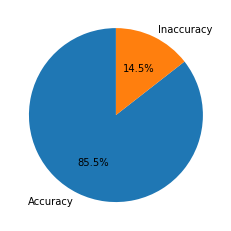

In [ ]:
import matplotlib.pyplot as plt

value = good

plt.pie([value, 1-value], labels=['Accuracy', 'Inaccuracy'], autopct='%1.1f%%', startangle=90)
plt.show()